In [13]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
import numpy as np
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

concentration_min, concentration_max, concentration_step = [2.5, 20, 2.5]  # Unit: concentration% ## 8 steps
concentration_var = np.arange(concentration_min, concentration_max + concentration_step, concentration_step)
concentration_num = len(concentration_var)

voltage_min, voltage_max, voltage_step = [10, 40, 2.5]  ## Unit: kV ## 13 steps
voltage_var = np.arange(voltage_min, voltage_max + voltage_step, voltage_step)
voltage_num = len(voltage_var)

height_min, height_max, height_step = [100, 200, 10]  ## Unit: mm ## 11 steps
height_var = np.arange(height_min, height_max + height_step, height_step)
height_num = len(height_var)

# dist_min, dist_max, dist_step = [25, 200, 5]  ## Unit: microns ## 7 steps
# dist_var = np.arange(dist_min, dist_max + dist_step, dist_step)
# dist_num = len(dist_var)

# dmso_min, dmso_max, dmso_step = [0, 100, 5]  # Unit: %DMSO ## 3 steps
# dmso_var = np.arange(dmso_min, dmso_max + dmso_step, dmso_step)
# dmso_num = len(dmso_var)

# sub_temp_min, sub_temp_max, sub_temp_step = [50, 200, 5]  ## Unit: degC ## 30 steps
# sub_temp_var = np.arange(sub_temp_min, sub_temp_max + sub_temp_step, sub_temp_step)
# sub_temp_num = len(sub_temp_var)

# anneal_min, anneal_max, anneal_step = [0, 10, 2.5]  ## Unit: Minutes ## 5 steps
# anneal_var = np.arange(anneal_min, anneal_max + anneal_step, anneal_step)
# anneal_num = len(anneal_var)

########## Create process variable array ##########
var_array = [
    concentration_var,
    voltage_var,
    height_var,
    # dist_var,
    # dmso_var,
    # sub_temp_var,
    # anneal_var,
]

########## Create labels for process variable array, making sure order is same as var_array ##########
x_labels = [
    "Concentration [%]",
    "Voltage [kV]",
    "Stage Height [mm]",
    # "Distance [microns]",
    # "DMSO [%]",
    # "Substrate Temperature [°C]",
    # "Annealing Time [min]"
]


In [14]:
parameter_space = ParameterSpace([ContinuousParameter('Concentration', 0, 1),
                                 ContinuousParameter('Voltage', 0, 1),
                                 ContinuousParameter('Stage Height', 0, 1),
                                #  ContinuousParameter('Distance', 0, 1),
                                #  ContinuousParameter('DMSO', 0, 1),
                                #  ContinuousParameter('SubTemp', 0, 1),
                                #  ContinuousParameter('Anneal', 0, 1),
                                 ])

def x_normalizer(X):

    def max_min_scaler(x, x_max, x_min):
        return (x - x_min) / (x_max - x_min)

    x_norm = []
    for x in X:
        x_norm.append(
            [
                max_min_scaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_norm)


def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x * (x_max - x_min) + x_min

    x_original = []
    for x in x_norm:
        x_original.append(
            [
                max_min_rescaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_original)


def get_closest_array(suggested_x):

    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value: abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value

    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append(
            [get_closest_value(x[i], var_list[i]) for i in range(len(x))]
        )
    return np.array(modified_array)

In [15]:
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
import pandas as pd

num_data_points = 10
# Set the random seed
np.random.seed(69)
latin = LatinDesign(parameter_space)
random = RandomDesign(parameter_space)

X_norm_latin = latin.get_samples(num_data_points)
x_denorm_latin = x_denormalizer(X_norm_latin)
X_denorm_close_latin = get_closest_array(x_denorm_latin)

# print(x_denorm)
df_X_new_latin = pd.DataFrame(X_denorm_close_latin, columns=parameter_space.parameter_names)
df_X_new_latin

print(df_X_new_latin)


# # x_test = np.array([[1.2, 125, 2, 110, 50, 125, 5]])
# x_test = np.array([[0, 0, 0, 0, 0, 0, 0]])
# x_test = np.array([[-0.0625, -0.016666666666666666, -0.1, -0.014285714285714285, -0.025, -0.016666666666666666, -0.125]])
# print(get_closest_array(x_denormalizer(x_test)))

   Concentration  Voltage  Stage Height
0            7.5     22.5         170.0
1           15.0     35.0         120.0
2           17.5     12.5         130.0
3           15.0     32.5         160.0
4            2.5     27.5         140.0
5           10.0     20.0         150.0
6           12.5     15.0         190.0
7           20.0     30.0         180.0
8            5.0     17.5         100.0
9            7.5     37.5         110.0


## Pairwise for Latin

<Figure size 3000x3000 with 0 Axes>

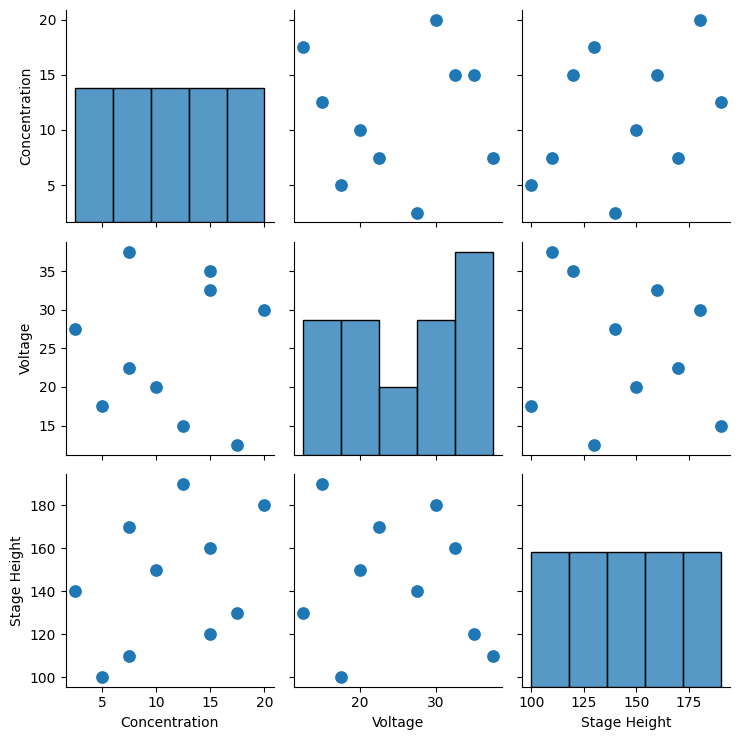

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# Pairwise density plots
plt.figure(figsize=(10, 10), dpi=300)
sns.pairplot(df_X_new_latin, kind='scatter', plot_kws={'s': 100}) # kde for Kernel Density Estimate\
plt.tight_layout()

plt.show()